台灣最常見的八哥有 (土) 八哥、白尾八哥及家八哥三種。我們來挑戰三種八哥總共用不到三十張照片, 看能不能打造一個神經網路學會辨識這三種八哥。

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2023-11-26 11:07:39.591259: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 11:07:39.643137: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:07:39.643190: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:07:39.644664: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:07:39.652765: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-26 11:07:40.872117: W tensorflow/compiler/tf2tensorrt/utils/py_utils.

### 1. 讀入八哥資料圖檔

In [3]:
!wget --no-check-certificate \
    https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip \
    -O myna.zip

--2023-11-26 11:07:41--  https://github.com/yenlung/Deep-Learning-Basics/raw/master/images/myna.zip
正在查找主機 github.com (github.com)... 20.27.177.113
正在連接 github.com (github.com)|20.27.177.113|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 302 Found
位置：https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip [跟隨至新的 URL]
--2023-11-26 11:07:42--  https://raw.githubusercontent.com/yenlung/Deep-Learning-Basics/master/images/myna.zip
正在查找主機 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
正在連接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 連上了。
已送出 HTTP 要求，正在等候回應... 200 OK
長度: 964098 (942K) [application/zip]
儲存到：‘myna.zip’

myna.zip            100%[===================>] 941.50K  1.26MB/s    於 0.7s     

2023-11-26 11:07:43 (1.26 MB/s) - 已儲存 ‘myna.zip’ [964098/964098]



In [4]:
import os
import zipfile

local_zip = 'myna.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('./content')
zip_ref.close()

In [5]:
base_dir = './content/'

In [6]:
myna_folders = ['crested_myna', 'javan_myna', 'common_myna']

我們可以列出在某個資料夾的檔名! 比方說（土）八哥是這樣。

In [7]:
thedir = base_dir + myna_folders[0]
os.listdir(thedir)

['crested_myna02.jpg', 'crested_myna01.jpg', 'crested_myna03.jpg']

接下來，我們要將這三個資料夾底下的照片作成輸入 (data)、輸出 (target)。

In [8]:
data = []
target = []
for i in range(3):
    thedir = base_dir + myna_folders[i]
    myna_fnames = os.listdir(thedir)
    for myna in myna_fnames:
        img_path = thedir + '/' + myna
        img = load_img(img_path , target_size = (256,256))
        x = img_to_array(img)
        data.append(x)
        target.append(i)

In [9]:
data = np.array(data)

順便看一下我們總共有多少張圖片

In [10]:
data.shape

(23, 256, 256, 3)

接著，隨便挑一張照片來看看它是什麼「鳥」樣

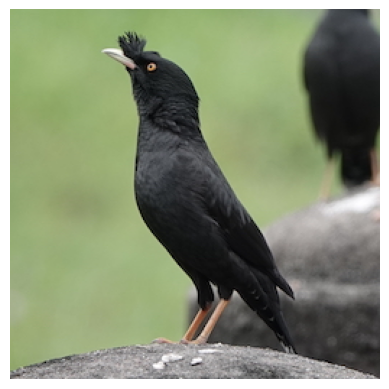

In [11]:
n = 1
plt.imshow(data[n]/255)
plt.axis('off');

看來沒有什麼意外, 就是個鳥圖。我們用 ResNet 的預處理再看一次。

In [12]:
x_train = preprocess_input(data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


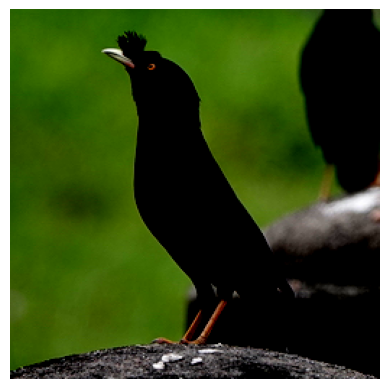

In [13]:
plt.imshow(x_train[n])
plt.axis('off');

這邊會跳出一個小小的警告，這是因為 ResNet 的預處理會將圖片的數據範圍常規化到 [-1, 1] 之間，與我們之前常規化到 [0, 1] 之間差一點點，所以畫圖時，matplotlib會自動作一些調整

每張圖的答案就是 0, 1, 2 其中一個數字。

In [14]:
target[n]

0

做 one-hot enconding。

In [15]:
y_train = to_categorical(target, 3)

In [16]:
y_train[0]

array([1., 0., 0.], dtype=float32)

### 3. 用 ResNet50 打造我們的神經網路

ResNet50 是 2015 ImageNet 的冠軍, 我們用第二版來試試。原本 ImageNet 是做了 1,000 個類別的圖形辨識。我們想直接用來辨識八哥, 就是把最後一層 (通常就 1,000 個輸出的 dense 層) 砍掉 (`include_top=False`), 然後換我們的就好。

再來我們可以把每個 filter 的結果做個大總合, 例如算每個 filter 計分板的總平均 (global average pooling), 這本來該我們自己做, 但是 `tf.Keras` 是善良無比的幫我們做好。只要下個參數 `pooling="avg"`)。

In [17]:
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [18]:
resnet = ResNet50V2(include_top=False, pooling="avg")

2023-11-26 11:07:44.756796: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


再來就是正式打造我們遷移學習版的函數學習機! 可以發現我們只是加入了最後一層...

In [19]:
model = Sequential()

In [20]:
model.add(resnet)

In [21]:
model.add(Dense(3, activation='softmax'))

我們是遷移式學習, 原本 ResNet 的部份我們當然沒有重新訓練的意思。於是就設這邊不需要訓練。

In [22]:
resnet.trainable = False

#### 欣賞我們的神經網路

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 dense (Dense)               (None, 3)                 6147      
                                                                 
Total params: 23570947 (89.92 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


#### 組裝我們的函數學習機

這裡我們用分類時非常標準的 `categorical_crossentropy`, 順便試試有名的 `adam` 學習法。

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

我們可以發現原來有超過兩千萬個參數, 經我們偷來, 不是, 借來以後, 只有 6,147 個參數要調。

### 4. 訓練 fit

這裡我們全部的資料也只有 23 筆, 所以 `batch_size` 就選擇 23 了...

In [25]:
model.fit(x_train, y_train, batch_size=23, epochs=10)

Epoch 1/10
1/1 [==============================] - 10s 10s/step - loss: 1.1936 - accuracy: 0.2609
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 0.9222 - accuracy: 0.5652
Epoch 3/10
1/1 [==============================] - 6s 6s/step - loss: 0.7923 - accuracy: 0.6522
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 0.7293 - accuracy: 0.6957
Epoch 5/10
1/1 [==============================] - 6s 6s/step - loss: 0.6834 - accuracy: 0.6957
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.6361 - accuracy: 0.6957
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.5851 - accuracy: 0.7391
Epoch 8/10
1/1 [==============================] - 5s 5s/step - loss: 0.5316 - accuracy: 0.7826
Epoch 9/10
1/1 [==============================] - 6s 6s/step - loss: 0.4772 - accuracy: 0.8696
Epoch 10/10
1/1 [==============================] - 6s 6s/step - loss: 0.4233 - accuracy: 0.8696


### 5. 預測

我們先用 model.evaluate 看一下模型表現得如何

In [26]:
loss, acc = model.evaluate(x_train, y_train)
print(f"Loss: {loss}")
print(f"Accuracy: {acc}")

1/1 [==============================] - 7s 7s/step - loss: 0.3715 - accuracy: 0.8696
Loss: 0.37146782875061035
Accuracy: 0.8695651888847351


為了後面的需要，我們將三種八哥的答案給寫成 `labels`

In [27]:
labels = ["土八哥", "白尾八哥", "家八哥"]

對了, 為何這次我們沒有切測試一一資料呢? 那是因為畢竟我們全部只有 23 張照片，而且每種八哥的照片也沒幾張。我們可以看一下訓練成果。

In [28]:
y_predict = np.argmax(model.predict(x_train), -1)

1/1 [==============================] - 6s 6s/step


In [29]:
y_predict

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2])

好奇的話比較一下正確答案。

In [30]:
target

[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]

### 6. 用 `gradio` 打造八哥辨識 web app!

In [31]:
!pip install gradio

In [32]:
import gradio as gr

注意現在主函數和我們做辨識 Cooper 的例子很像, 只是現在我們只有三個種類。而且是我們的 model!

In [33]:
def classify_image(inp):
    inp = inp.reshape((-1, 256, 256, 3))
    inp = preprocess_input(inp)
    prediction = model.predict(inp).flatten()
    return {labels[i]: float(prediction[i]) for i in range(3)}

In [35]:
image = gr.Image(label="八哥照片")
label = gr.Label(num_top_classes=3, label="AI辨識結果")
some_text="我能辨識（土）八哥、白尾八哥、家八哥。找張八哥照片來考我吧!"

我們將八哥數據庫中的圖片拿出來當作範例圖片讓使用者使用

In [39]:
sample_images = []
for i in range(3):
    thedir = base_dir + myna_folders[i]
    for file in os.listdir(thedir):
        sample_images.append(myna_folders[i] + '/' + file)

最後，將所有東西組裝在一起，就大功告成了！

In [37]:
gr.Interface(fn=classify_image,
             inputs=image,
             outputs=label,
             title="AI 八哥辨識機",
             description=some_text,
             examples=sample_images).launch(share=True)

FileNotFoundError: [Errno 2] No such file or directory: '/home/jumbo/crested_myna/crested_myna02.jpg'